# Quickstart on MEP using Spark

This notebook shows the MEP quickstart sample, which also exists as a non-notebook version at:
https://git.vito.be/projects/BIGGEO/repos/python-spark-quickstart/browse

It shows how to use Spark (http://spark.apache.org/) for distributed processing on the PROBA-V Mission Exploitation Platform. (https://proba-v-mep.esa.int/) The sample intentionally implements a very simple computation: for each PROBA-V tile in a given bounding box and time range, a histogram is computed. The results are then summed and printed. Computation of the histograms runs in parallel.
## First step: get file paths
A catalog API is available to easily retrieve paths to PROBA-V files:
https://readthedocs.org/projects/mep-catalogclient/

In [4]:
# from catalogclient import catalog
from terracatalogueclient import Catalogue
# intialize the catalogueclient
catalogue = Catalogue()

In [5]:
# check the catalogs
collections = catalogue.get_collections()
for collection in collections:
    print(f"{collection.id}:{collection.properties['title']}")

urn:eop:VITO:CGS_S1_GRD_L1:Sentinel-1 Level-1 Ground Range Detected (GRD) products
urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1:Sentinel-1 Level-1 Ground Range Detected (GRD) SIGMA0 products
urn:eop:VITO:CGS_S1_SLC_L1:Sentinel-1 Level-1 Single Look Complex (SLC) products.
urn:eop:VITO:CGS_S2_L1C:Sentinel-2 Level-1C MSI product contains Top-of-atmosphere reflectances in cartographic geometry
urn:eop:VITO:COP_DEM_EU_25M:Copernicus European Digital Elevation Model (EU-DEM), version 1.1 in 25m resolution
urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus Global 30 meter Digital Elevation Model dataset in COG format  
urn:eop:VITO:COP_DEM_GLO_90M_COG:Copernicus Global 90 meter Digital Elevation Model dataset in COG format
urn:eop:VITO:ESA_WORLDCEREAL_ACTIVECROPLAND_V1:ESA WorldCereal products for active cropland per agro-ecological zone - V1
urn:eop:VITO:ESA_WORLDCEREAL_IRRIGATION_V1:ESA WorldCereal products for active irrigation per agro-ecological zone - V1
urn:eop:VITO:ESA_WORLDCEREAL_MAIZE_V1:ESA WorldCe

In [6]:
#let's filter on collections derived from ProbaV data and show resulution
collections = catalogue.get_collections(platform="PROBA-V")
for collection in collections:
    print("{}, format {}, resolution {} m".format(collection.id,
                                                  collection.properties["productInformation"]["format"],
                                                  collection.properties["productInformation"]["resolution"]))

urn:eop:VITO:PROBAV_L1C_HDF_V2, format HDF5, resolution [1000] m
urn:eop:VITO:PROBAV_L2A_100M_COG_V2, format geotiff, resolution [100] m
urn:eop:VITO:PROBAV_L2A_100M_HDF_V2, format HDF5, resolution [100] m
urn:eop:VITO:PROBAV_L2A_1KM_COG_V2, format geotiff, resolution [1000] m
urn:eop:VITO:PROBAV_L2A_1KM_HDF_V2, format HDF5, resolution [1000] m
urn:eop:VITO:PROBAV_L2A_333M_COG_V2, format geotiff, resolution [333] m
urn:eop:VITO:PROBAV_L2A_333M_HDF_V2, format HDF5, resolution [333] m
urn:eop:VITO:PROBAV_S10_TOC_1KM_COG_V2, format geotiff, resolution [1000] m
urn:eop:VITO:PROBAV_S10_TOC_1KM_HDF_V2, format HDF5, resolution [1000] m
urn:eop:VITO:PROBAV_S10_TOC_333M_COG_V2, format geotiff, resolution [333] m
urn:eop:VITO:PROBAV_S10_TOC_333M_HDF_V2, format HDF5, resolution [333] m
urn:eop:VITO:PROBAV_S10_TOC_NDVI_1KM_COG_V2, format geotiff, resolution [1000] m
urn:eop:VITO:PROBAV_S10_TOC_NDVI_1KM_HDF_V2, format HDF5, resolution [1000] m
urn:eop:VITO:PROBAV_S10_TOC_NDVI_333M_COG_V2, format ge

In [7]:
date = "2016-01-01"
products = list(catalogue.get_products('urn:eop:VITO:PROBAV_S10_TOC_NDVI_333M_COG_V2', 
                            
                            start=date, 
                            end=date, 
                            bbox=[0,36,10,53],accessedFrom="MEP"))
#extract NDVI geotiff files from product metadata
        
print('Found '+str(len(products)) + ' files.')
print(products[0])

# Extract local paths
files = [str(pf.href)[7:] for p in products for pf in p.data]

#check if file exists
!file {files[0]}

Found 4 files.
urn:eop:VITO:PROBAV_S10_TOC_NDVI_333M_COG_V2:PROBAV_S10_TOC_NDVI_X18Y02_20160101_333M_V201
/data/MTDA/PROBAV_C2/COG/PROBAV_L3_S10_TOC_NDVI_333M/2016/20160101/PROBAV_S10_TOC_NDVI_20160101_333M_V201/PROBAV_S10_TOC_NDVI_X18Y02_20160101_333M_NDVI_V201.TIFF: TIFF image data, little-endian


## Second step: define function to apply
Define the histogram function, this can also be done inline, which allows for a faster feedback loop when writing the code, but here we want to clearly separate the processing 'algorithm' from the parallelization code.

In [8]:
# Calculates the histogram for a given (single band) image file.
def histogram(image_file):
    
    import numpy as np
    import gdal
    
    
    # Open image file
    img = gdal.Open(image_file)
    
    if img is None:
        print( '-ERROR- Unable to open image file "%s"' % image_file )
    
    # Open raster band (first band)
    raster = img.GetRasterBand(1)    
    xSize = img.RasterXSize
    ySize = img.RasterYSize
    
    # Read raster data
    data = raster.ReadAsArray(0, 0, xSize, ySize)
        
    # Calculate histogram
    hist, _ = np.histogram(data, bins=256)
    return hist


## Third step: setup Spark
To work on the processing cluster, we need to specify the resources we want:

* spark.executor.cores: Number of cores per executor. Usually our tasks are single threaded, so 1 is a good default.
* spark.executor.memory: memory to assign per executor. For the Java/Spark processing, not the Python part.
* spark.yarn.executor.memoryOverhead: memory available for Python in each executor.

We set up the SparkConf with these parameters, and create a SparkContext sc, which will be our access point to the cluster.

In [9]:
%%time
# ================================================================
# === Calculate the histogram for a given number of files. The ===
# === processing is performed by spreading them over a cluster ===
# === of Spark nodes.                                          ===
# ================================================================

from datetime import datetime
from operator import add
import pyspark
import os
# Setup the Spark cluster
conf = pyspark.SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', 512)
conf.set('spark.executor.memory', '512m')

sc = pyspark.SparkContext(conf=conf)

CPU times: user 212 ms, sys: 23.7 ms, total: 236 ms
Wall time: 19 s


## Fourth step: compute histograms
We use a couple of Spark functions to run our job on the cluster. Comments are provided in the code.

In [10]:
# confirm that files are in local directory
files[0]

'/data/MTDA/PROBAV_C2/COG/PROBAV_L3_S10_TOC_NDVI_333M/2016/20160101/PROBAV_S10_TOC_NDVI_20160101_333M_V201/PROBAV_S10_TOC_NDVI_X18Y02_20160101_333M_NDVI_V201.TIFF'

In [11]:
%%time
# Distribute the local file list over the cluster.
filesRDD = sc.parallelize(files,len(files))

# Apply the 'histogram' function to each filename using 'map', keep the result in memory using 'cache'.
hists = filesRDD.map(histogram).cache()

count = hists.count()

# Combine distributed histograms into a single result
total = list(hists.reduce(lambda h, i: map(add, h, i)))
hists.unpersist()

print( "Sum of %i histograms: %s" % (count, total))

Sum of 8 histograms: [7419777, 369118, 321208, 379553, 337595, 356208, 363108, 338192, 329695, 342966, 307351, 319770, 290165, 257097, 276476, 275767, 262727, 265111, 222536, 173434, 472451, 210552, 273435, 323724, 332874, 352081, 357942, 366146, 375739, 389370, 357305, 328416, 307390, 285066, 259598, 229796, 208277, 194679, 184153, 178935, 172341, 166085, 162579, 161132, 158542, 157937, 156283, 154815, 155798, 155937, 157140, 157140, 157806, 157556, 159392, 158681, 159116, 160080, 158958, 159288, 158257, 158310, 157975, 156517, 155359, 154995, 152536, 151728, 151007, 149905, 148497, 147302, 147831, 146674, 145408, 145755, 144115, 144107, 143626, 143654, 143761, 143196, 141088, 145660, 143238, 143730, 144961, 144633, 145133, 146238, 146051, 147379, 148088, 148503, 150250, 151445, 151562, 153079, 154247, 155148, 156120, 157762, 159487, 159704, 161257, 163062, 163519, 165979, 165578, 167798, 168500, 169718, 171454, 173147, 173672, 174496, 174667, 176756, 176174, 178404, 179020, 179879, 1

In [12]:
#stop spark session if we no longer need it
sc.stop()

## Fifth step: plot our result
Plot the array of values as a simple line chart using matplotlib. This is the most basic Python library. More advanced options such as bokeh, mpld3 and seaborn are also available.

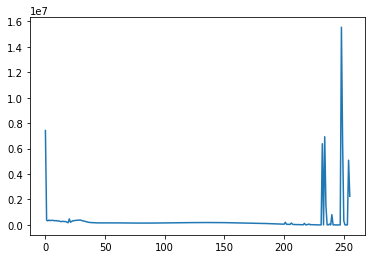

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(total)
plt.show()